In [3]:
import pandas as pd

# Charger quelques lignes pour voir la structure
df_train = pd.read_csv("data/mitbih_train.csv", header=None)
df_test = pd.read_csv("data/mitbih_test.csv", header=None)

print(df_train.shape)    # doit être (nombre_exemples, 188)
print(df_train.head())

# Afficher la colonne 187 (dernière colonne)
print(df_train[187].value_counts())  # Cela doit afficher la distribution des classes 0,1,2,3,4


(87554, 188)
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  

In [4]:
X = df_train.iloc[:, 0:187].values
y = df_train.iloc[:, 187].values

print("Shape des features X :", X.shape)
print("Shape des labels y :", y.shape)
print("Labels uniques :", set(y))
print("Exemples de labels :", y[:10])

Shape des features X : (87554, 187)
Shape des labels y : (87554,)
Labels uniques : {0.0, 1.0, 2.0, 3.0, 4.0}
Exemples de labels : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, BatchNormalization
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

# === 1. Split train/validation (80/20) ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# === 2. Normalisation ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# === 3. Reshape pour CNN/LSTM ===
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# === 4. One-hot encoder les labels ===
y_train_cat = to_categorical(y_train, num_classes=5)
y_val_cat = to_categorical(y_val, num_classes=5)


In [22]:
# === 5. Définir la couche d'attention personnalisée ===
from keras.saving import register_keras_serializable
from keras.layers import Layer
import tensorflow as tf

@register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.linalg.matmul(x, self.W) + self.b)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.keras.activations.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

In [9]:

# === 6. Construire le modèle ===
input_layer = Input(shape=(X_train.shape[1], 1))

x = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)

x = Attention()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(5, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 185, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 92, 128)        │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 92, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 92, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 64)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,777 (374.13 KB)

 Trainable params: 95,713 (373.88 KB)

 Non-trainable params: 64 (256.00 B)

In [10]:
# === 7. Entraînement ===
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=64
)

Epoch 1/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 129s 114ms/step - accuracy: 0.8800 - loss: 0.4393 - val_accuracy: 0.9623 - val_loss: 0.1397
Epoch 2/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.9616 - loss: 0.1437 - val_accuracy: 0.9737 - val_loss: 0.1037
Epoch 3/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 120s 110ms/step - accuracy: 0.9718 - loss: 0.1085 - val_accuracy: 0.9774 - val_loss: 0.0892
Epoch 4/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 124s 113ms/step - accuracy: 0.9747 - loss: 0.0960 - val_accuracy: 0.9782 - val_loss: 0.0784
Epoch 5/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 127s 116ms/step - accuracy: 0.9762 - loss: 0.0897 - val_accuracy: 0.9778 - val_loss: 0.0779
Epoch 6/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.9778 - loss: 0.0789 - val_accuracy: 0.9785 - val_loss: 0.0725
Epoch 7/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 129s 118ms/step - accuracy: 0.9802 - loss: 0.0701 - val_accuracy: 0.9816 - val_loss: 0.0695
Epoch 8/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 127s 116ms/step - ac

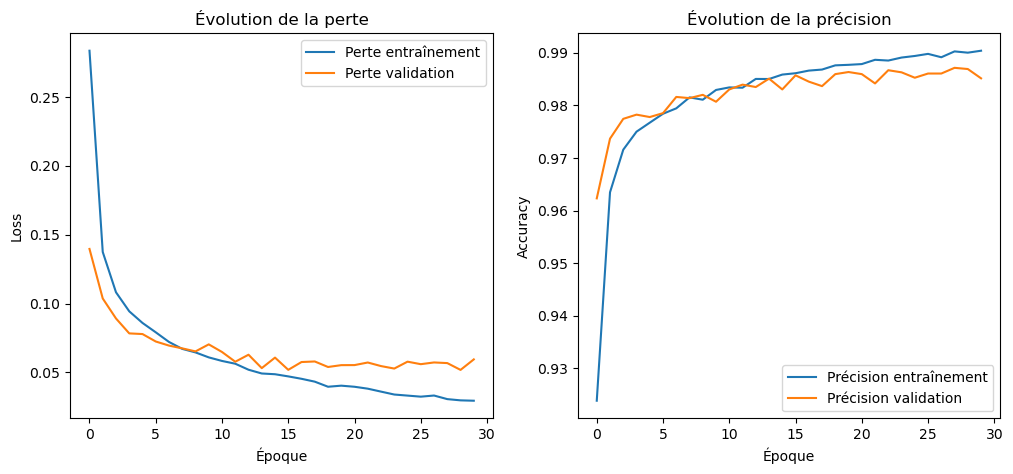

In [11]:
import matplotlib.pyplot as plt

# Afficher la courbe de perte
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Évolution de la perte')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

# Afficher la courbe de précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title('Évolution de la précision')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
# Séparer features et labels
X_test = df_test.iloc[:, 0:187].values
y_test = df_test.iloc[:, 187].values

# Normaliser (utiliser le même scaler que pour train)
X_test = scaler.transform(X_test)

# Reshape pour CNN/LSTM
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Encoder les labels
y_test_cat = to_categorical(y_test, num_classes=5)

# Prédictions sur le jeu de test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # classes prédites
y_true = y_test

685/685 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step


685/685 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step


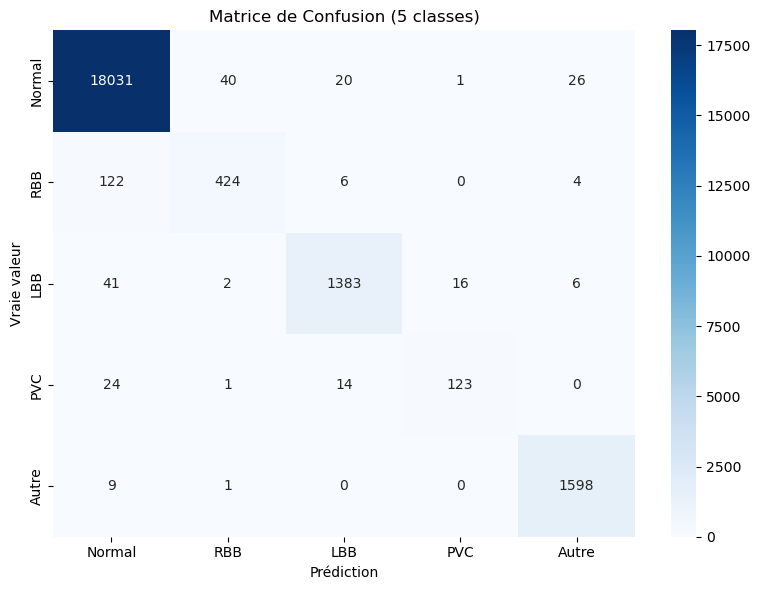


🧾 Rapport de classification (5 classes) :
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     18118
         RBB       0.91      0.76      0.83       556
         LBB       0.97      0.96      0.96      1448
         PVC       0.88      0.76      0.81       162
       Autre       0.98      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.94      0.89      0.92     21892
weighted avg       0.98      0.98      0.98     21892



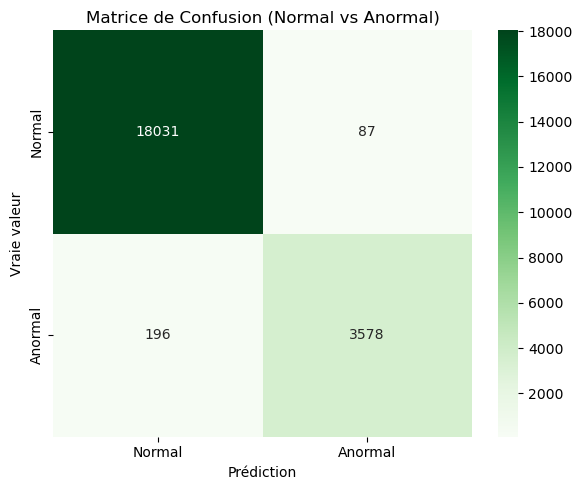


🧾 Rapport de classification (Normal vs Anormal) :
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     18118
     Anormal       0.98      0.95      0.96      3774

    accuracy                           0.99     21892
   macro avg       0.98      0.97      0.98     21892
weighted avg       0.99      0.99      0.99     21892



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Prédictions ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test  # déjà sous forme d'entiers

# === Dictionnaire des classes ===
classes = {
    0: "Normal : ECG normal sans anomalie.",
    1: "RBB : Bloc de branche droit.",
    2: "LBB : Bloc de branche gauche.",
    3: "PVC : Contraction ventriculaire prématurée.",
    4: "Autre : Autres anomalies cardiaques."
}

# === Matrice de confusion (5 classes) ===
cm_5 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_5, annot=True, fmt="d", cmap="Blues",
            xticklabels=[classes[i].split(" :")[0] for i in range(5)],
            yticklabels=[classes[i].split(" :")[0] for i in range(5)])
plt.title("Matrice de Confusion (5 classes)")
plt.xlabel("Prédiction")
plt.ylabel("Vraie valeur")
plt.tight_layout()
plt.show()

# === Rapport de classification détaillé ===
print("\n🧾 Rapport de classification (5 classes) :")
print(classification_report(y_true, y_pred, target_names=[classes[i].split(" :")[0] for i in range(5)]))


# === Matrice binaire (Normal vs Anormal) ===
y_true_binary = np.where(y_true == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)

cm_2 = confusion_matrix(y_true_binary, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Normal", "Anormal"],
            yticklabels=["Normal", "Anormal"])
plt.title("Matrice de Confusion (Normal vs Anormal)")
plt.xlabel("Prédiction")
plt.ylabel("Vraie valeur")
plt.tight_layout()
plt.show()

# === Rapport binaire ===
print("\n🧾 Rapport de classification (Normal vs Anormal) :")
print(classification_report(y_true_binary, y_pred_binary, target_names=["Normal", "Anormal"]))


685/685 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step


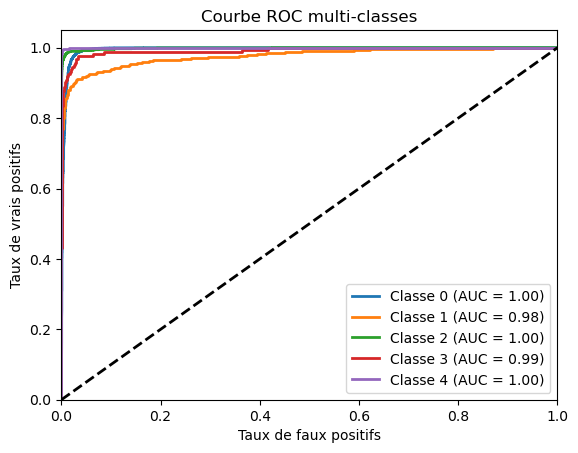

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binariser les labels
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])

# Prédictions probabilistes
y_score = model.predict(X_test)

n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Classe %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC multi-classes')
plt.legend(loc="lower right")
plt.show()


In [18]:
# Sauvegarde du modèle
model.save("ECG_model.keras", save_format="keras")

# Sauvegarde du scaler
import joblib
joblib.dump(scaler, "ECG_scaler.gz")


['ECG_scaler.gz']